In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using DSP
# using BenchmarkTools
using Optim

In [2]:
include("../src/likelihood.jl")
include("../src/utill.jl")

plot_cam_crossections (generic function with 1 method)

# Load Data:

In [3]:
conv_mat = load("../data/experiment/m2/conv_matrix-2.jld2")

conv_matrices = (
    cam_1 = conv_mat["cam_1"],
    cam_2 = conv_mat["cam_2"],
    cam_3 = conv_mat["cam_3"],
    cam_4 = conv_mat["cam_3"],
);


# Likelihood Function:

In [36]:
param = (
        tr_size = [0.15, 0.15],
        ang_spr = [4.0, 4.0],
        s_waist = [2.9,],
        μ_x = [46,50,20,115], # alignment X
        μ_y = [48,50,25,160], # alignment Y
        σ_x = [1,3,6,10], # resolution X
        σ_y = [1,3,6,10], # resolution Y
        δ_x = [0.0271,0.0216,0.114,0.0303], # pixel size X
        δ_y = [0.0305,0.0234,0.125,0.0298], # pixel size Y
        int_coeff  = [34896.560, 50315.113, 10317.860, 310986.998], # light intensity coefficient
        s_cam = [0.0, 1.478, 15.026, 23.1150], # camera position
    );

event = generate_event(param, 25.0, conv_matrices)

(cam_1 = [1 2 … 2 1; 11 1 … 8 2; … ; 224 4 … 1 25; 10 18 … 263 5], cam_2 = [0 8 … 10 105; 4 2 … 1 0; … ; 1 1 … 1 6; 1 3 … 1 0], cam_3 = [6 4 … 13 3; 7 9 … 209 36; … ; 9 11 … 279 2; 0 1 … 7 161], cam_4 = [1 3 … 80 321; 117 7 … 361 6; … ; 2 10 … 3 8; 14 2 … 65 34], population = 25.0)

In [49]:
# Generate 5 simulated Events: 

# sim_events = [generate_event(param, 25.0, conv_matrices) for i in 1:5]

# FileIO.save("../data/experiment/m2/simulated_events.jld2", 
#     Dict("array" => sim_events))

In [5]:
images = load("../data/experiment/m2/images-2.jld2");

event_number = 2

event = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
)

param = (
        tr_size = [0.15, 0.15],
        ang_spr = [4.0, 4.0],
        s_waist = [2.9,],
        μ_x = [46,50,20,115], # alignment X
        μ_y = [48,50,25,160], # alignment Y
        σ_x = [2,2,2,5], # resolution X
        σ_y = [2,2,2,5], # resolution Y
        δ_x = [0.0271,0.0216,0.114,0.0303], # pixel size X
        δ_y = [0.0305,0.0234,0.125,0.0298], # pixel size Y
        int_coeff  = [34896.560, 50315.113, 10317.860, 310986.998], # light intensity coefficient
        s_cam = [0.0, 1.478, 15.026, 23.1150], # camera position
    );


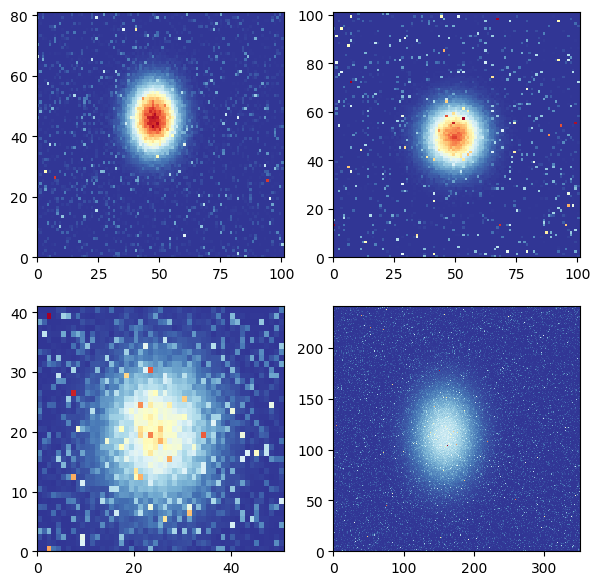

PyObject <matplotlib.collections.QuadMesh object at 0x7ffc13c6e6d0>

In [37]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(event[1], cmap="RdYlBu_r")
ax[1,2].pcolormesh(event[2], cmap="RdYlBu_r")
ax[2,1].pcolormesh(event[3], cmap="RdYlBu_r")
ax[2,2].pcolormesh(event[4], cmap="RdYlBu_r")

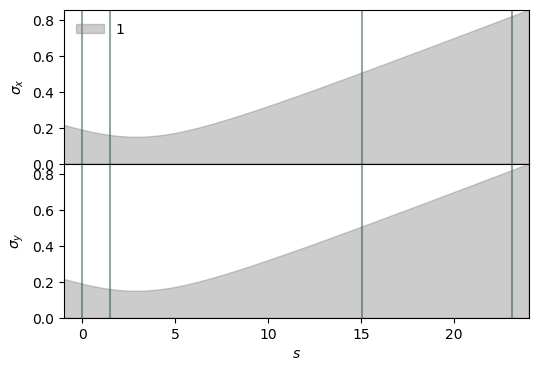

PyObject Text(0.5, 24.0, '$s$')

In [38]:
plot_envelop_trajectory([param,])

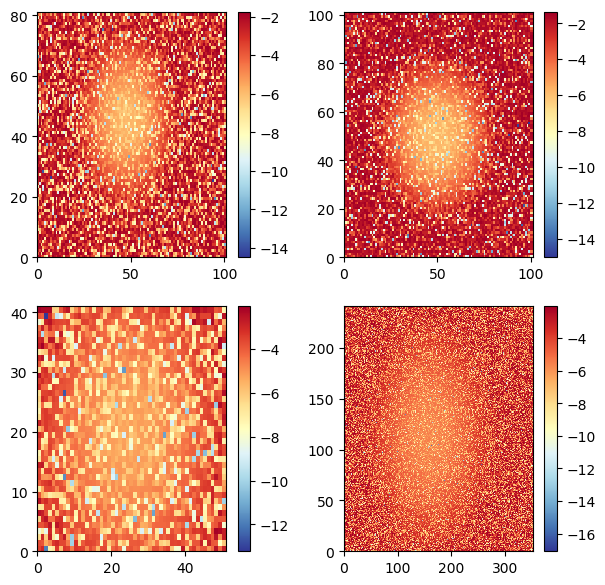

PyObject <matplotlib.colorbar.Colorbar object at 0x7ffc14d5f350>

In [39]:
log_lik_1 = cam_likelihood_debug(param, event[1], event.population, conv_matrices.cam_1, 1);
log_lik_2 = cam_likelihood_debug(param, event[2], event.population, conv_matrices.cam_2, 2);
log_lik_3 = cam_likelihood_debug(param, event[3], event.population, conv_matrices.cam_3, 3);
log_lik_4 = cam_likelihood_debug(param, event[4], event.population, conv_matrices.cam_4, 4);

# fig, ax = plt.subplots(1,1, figsize=(5,5))
# im = ax.pcolormesh(log_lik, cmap="RdYlBu_r")
# cbar = fig.colorbar(im)

fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.3)

im1 = ax[1,1].pcolormesh(log_lik_1, cmap="RdYlBu_r")
cbar = fig.colorbar(im1, ax=ax[1,1])

im2 = ax[1,2].pcolormesh(log_lik_2, cmap="RdYlBu_r")
cbar = fig.colorbar(im2, ax=ax[1,2])

im3 = ax[2,1].pcolormesh(log_lik_3, cmap="RdYlBu_r")
cbar = fig.colorbar(im3, ax=ax[2,1])

im4 = ax[2,2].pcolormesh(log_lik_4, cmap="RdYlBu_r")
cbar = fig.colorbar(im4, ax=ax[2,2])


In [40]:
# @benchmark total_likelihood($param, $toy_event, $conv_matrices)

total_likelihood(param, event, conv_matrices)

-480778.4884215937

# Optimization:

In [41]:
function vect_to_nt(x::AbstractVector)
    return (
        tr_size = [x[1],x[2]],
        ang_spr = [x[3], x[4]],
        s_waist = [x[5],],
        μ_x = [x[6],x[7],x[8],x[9]], 
        μ_y = [x[10],x[11],x[12],x[13]], 
        σ_x = [x[14],x[15],x[16],x[17]], 
        σ_y = [x[18],x[19],x[20],x[21]], 
        δ_x = [x[22],x[23],x[24],x[25]], 
        δ_y = [x[26],x[27],x[28],x[29]], 
        int_coeff  = [x[30],x[31],x[32],x[33]], 
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    )
end

function nt_to_vect(x::N) where {N <: NamedTuple}
    return [
        x.tr_size..., 
        x.ang_spr..., 
        x.s_waist..., 
        x.μ_x..., 
        x.μ_y..., 
        x.σ_x..., 
        x.σ_y..., 
        x.δ_x..., 
        x.δ_y..., 
        x.int_coeff...,
    ]
end

function opt_function(x; event=event, cv = conv_matrices)
    nt = vect_to_nt(x)
    return abs.(total_likelihood(nt, event, cv))
end

opt_function (generic function with 1 method)

In [42]:
x_0 = nt_to_vect(param)

opt_output = optimize(opt_function, x_0)

opt_parameters = vect_to_nt(opt_output.minimizer);

In [43]:
opt_output.minimizer

33-element Array{Float64,1}:
      0.15228256100628815
      0.15241438294252424
      4.035829309612272
      4.024328679842007
      2.9366174723715632
     46.041561442309906
     50.002993766905774
     20.00320474098712
    115.00522847512298
     48.00219254738559
     50.00149751698032
     25.01246656805448
    160.02787269841573
      ⋮
      0.027435255971665157
      0.021821645246955505
      0.1279103280341825
      0.03012014985995244
      0.030921120061558578
      0.023591685010753198
      0.1395439032343211
      0.02964854629673767
  35081.43361101892
  50359.836075312676
  10508.749067377245
 312994.15936063806

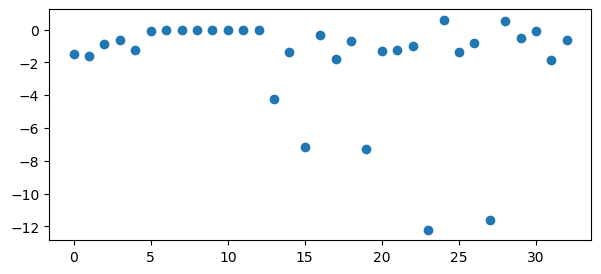

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ffca1512d10>

In [44]:
per_div = 100 .* (x_0 .- opt_output.minimizer) ./ x_0

fig, ax = plt.subplots(1,1, figsize=(7,3))

ax.plot(per_div, "o")

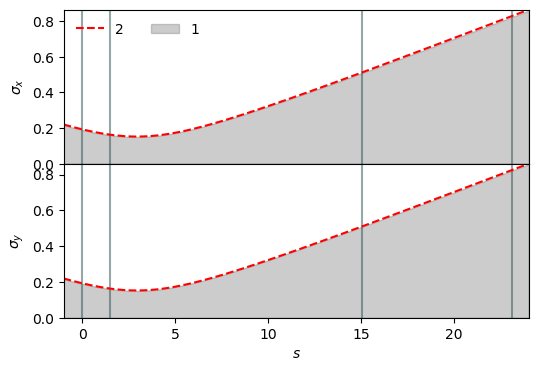

PyObject Text(0.5, 24.0, '$s$')

In [45]:
plot_vector = [param, opt_parameters,]

plot_envelop_trajectory(plot_vector)

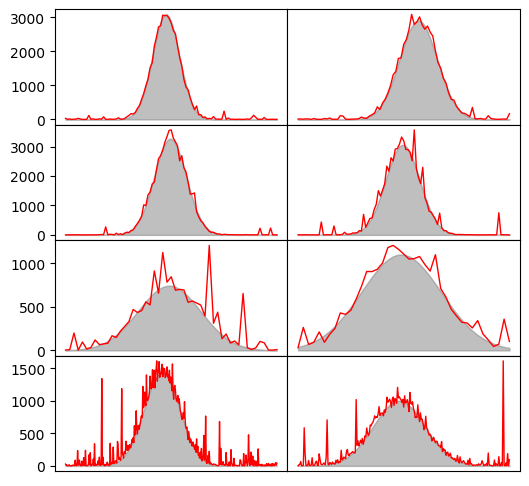

In [46]:
plot_cam_crossections([opt_parameters,], event, conv_matrices)

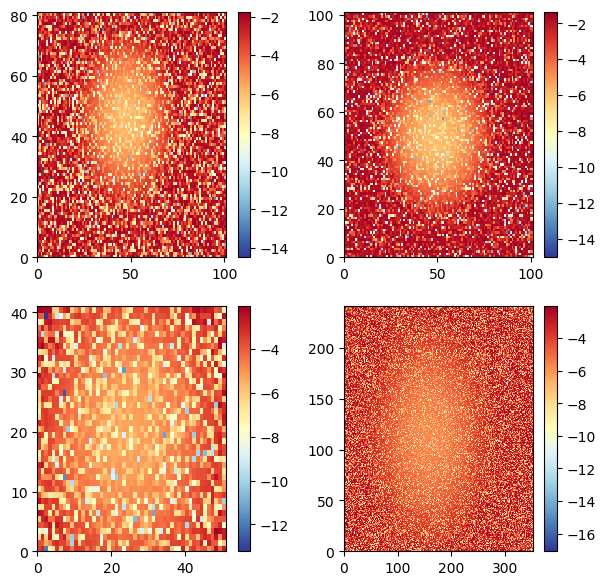

PyObject <matplotlib.colorbar.Colorbar object at 0x7ffcbcd5d510>

In [47]:
log_lik_1 = cam_likelihood_debug(opt_parameters, event[1], event.population, conv_matrices.cam_1, 1);
log_lik_2 = cam_likelihood_debug(opt_parameters, event[2], event.population, conv_matrices.cam_2, 2);
log_lik_3 = cam_likelihood_debug(opt_parameters, event[3], event.population, conv_matrices.cam_3, 3);
log_lik_4 = cam_likelihood_debug(opt_parameters, event[4], event.population, conv_matrices.cam_4, 4);

# fig, ax = plt.subplots(1,1, figsize=(5,5))
# im = ax.pcolormesh(log_lik, cmap="RdYlBu_r")
# cbar = fig.colorbar(im)

fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.3)

im1 = ax[1,1].pcolormesh(log_lik_1, cmap="RdYlBu_r")
cbar = fig.colorbar(im1, ax=ax[1,1])

im2 = ax[1,2].pcolormesh(log_lik_2, cmap="RdYlBu_r")
cbar = fig.colorbar(im2, ax=ax[1,2])

im3 = ax[2,1].pcolormesh(log_lik_3, cmap="RdYlBu_r")
cbar = fig.colorbar(im3, ax=ax[2,1])

im4 = ax[2,2].pcolormesh(log_lik_4, cmap="RdYlBu_r")
cbar = fig.colorbar(im4, ax=ax[2,2])


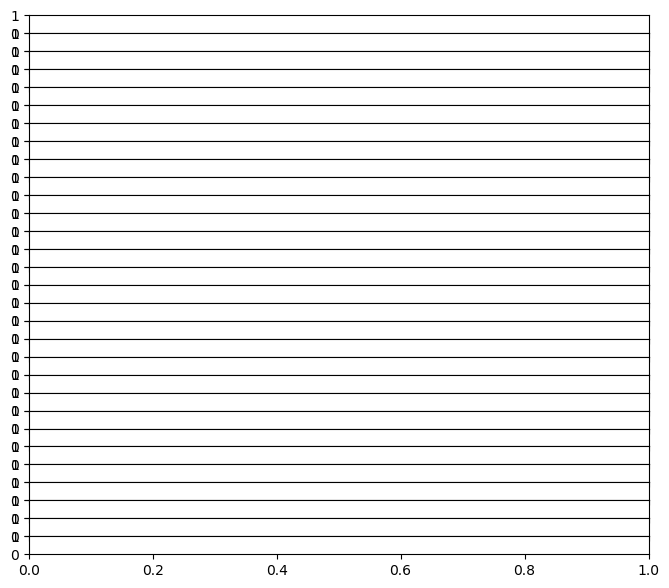

In [56]:
fig, ax = plt.subplots(30,1, figsize=(8,7), sharex=true)
fig.subplots_adjust(hspace=0.0, wspace=0.0)